In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob 
from common.trajectory_analysis import Trajectory
from common.util import DelayLine
import scipy
from scipy.stats import pearsonr

In [2]:
def interpolate(ts, xs, new_ts):
    x_spline = scipy.interpolate.UnivariateSpline(ts, xs, k=3, s=0)
    new_xs = x_spline(new_ts)
    return new_xs

In [3]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [4]:
pxtomm = 160/1080 #[mm/px] for Huion H610p

In [5]:
class Data:
    def __init__(self, filename, dt=0.005, cut = None, smooth_t=None, smooth_c=None):
        d = json.load(open(filename))
        self.filename = filename
        self.tts = np.array(d["tts"])  # time
        self.txs = np.array(d["txs"]) * pxtomm  # target x
        self.tys = np.array(d["tys"]) * pxtomm  # tatget y
        self.cxs = np.array(d["cxs"]) * pxtomm  # cursor (pen) x
        self.cys = np.array(d["cys"]) * pxtomm  # cursor (pen) y
        self.ss  = np.array(d["ss"]) * pxtomm   # sizes
        self.fs  = np.array(d["fs"])  # frequencies

        self.tr  = Trajectory(self.txs, self.tys, self.tts, dt = dt, cut=cut, smooth = smooth_t)
        self.cr  = Trajectory(self.cxs, self.cys, self.tts, dt = dt, cut=cut, smooth = smooth_c)        
        self.sst = interpolate(self.tts, self.ss, self.tr.t)
        self.a   = self.sst[:]
        self.b   = self.sst[:] / 2
        self.fst = interpolate(self.tts, self.fs, self.tr.t)        

        centerx, centery = center = 800*pxtomm, 450*pxtomm
        self.tph = np.unwrap(np.arctan2(self.tr.y - centery, self.tr.x - centerx))
        self.cph = np.unwrap(np.arctan2(self.cr.y - centery, self.cr.x - centerx))
        self.dph = self.cph - self.tph
        
        r =  np.array([distance((self.cr.x[i], self.cr.y[i]), center) for i in range(len(self.cr.t))])
        r_ratio = 2
        self.rc =  r *  np.sqrt(np.cos(self.cph)**2 + (r_ratio*np.sin(self.cph))**2)
        self.ds = self.a - self.rc
        


In [6]:
dt = 0.005

files = glob.glob("..//data3//*phase and size track*.json")
data = [Data(f, smooth_c = 10, cut=[4, 1], dt=dt) for f in files]

In [7]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99",
    "virtual":"#547dde",
    "model" : "#f6914b"
}

import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 15}
matplotlib.rc('font', **font)

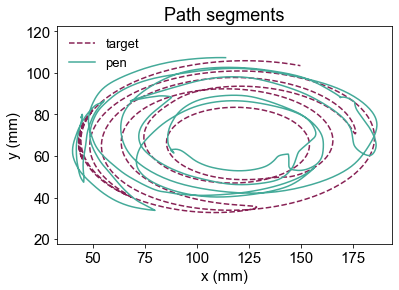

In [8]:
centerx = 800
centery = 450

d = data[2]

plt.figure(figsize=[6, 4])
plt.title("Path segments")

take = np.arange(int(10/dt), int(25/dt))
plt.plot(d.tr.x[take], d.tr.y[take], "--", color=colors["target"], label="target")
plt.plot(d.cr.x[take], d.cr.y[take], color=colors["cursor"], label="pen")
plt.axis("equal")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.legend(loc="upper left", frameon=False, prop={"size":13})
plt.savefig("..//figures//Figure 4, paths.eps", format="eps", bbox_inches="tight")
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


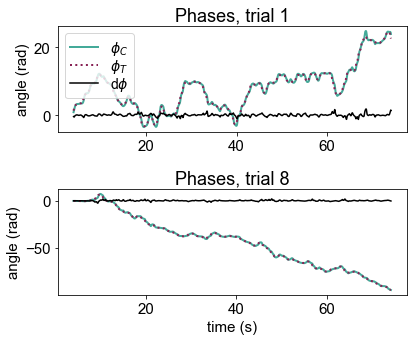

In [22]:
plt.figure(figsize=[6, 5])
plt.subplot(211)
plt.title("Phases, trial 1")
d = data[0]
t = d.tr.t
take = np.arange(int(0/dt), int(70/dt))
plt.plot(t[take], d.cph[take], color = colors["cursor"], label=r"$\phi_C$", lw=2)
plt.plot(t[take], d.tph[take], ":", color = colors["target"], label=r"$\phi_T$", lw=2)
plt.plot(t[take], d.dph[take], color="black", label=r"d$\phi$")
plt.ylabel("angle (rad)")
plt.legend(loc="upper left", prop={'size': 14}, labelspacing=0)

plt.subplot(212)
plt.title("Phases, trial 8")
d = data[7]
t = d.tr.t
take = np.arange(int(0/dt), int(70/dt))
plt.plot(t[take], d.cph[take], color = colors["cursor"], label=r"$\phi_C$", lw=2)
plt.plot(t[take], d.tph[take], ":", color = colors["target"], label=r"$\phi_T$", lw=2)
plt.plot(t[take], d.dph[take], color="black", label=r"d$\phi$")


plt.ylabel("angle (rad)")
plt.xlabel("time (s)")
plt.tight_layout()
plt.savefig("..//figures//Figure 4, phases2.eps", format="eps",  bbox_inches="tight")

plt.show()

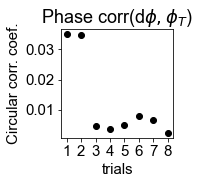

In [11]:
from common.circstats import corrcc as cc

plt.figure(figsize=[2, 2])

phase_corrs = [abs(cc(d.dph, d.tph)) for d in data ]
x = np.arange(len(data)) + 1

plt.ylabel("Circular corr. coef.")

plt.title(r"Phase corr(d$\phi,  \phi_T$)")
plt.scatter(x, phase_corrs, color="black")

plt.xticks(x)
plt.xlabel("trials")
plt.savefig("..//figures//Figure 4, phases correlations2.eps", format="eps", bbox_inches="tight")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


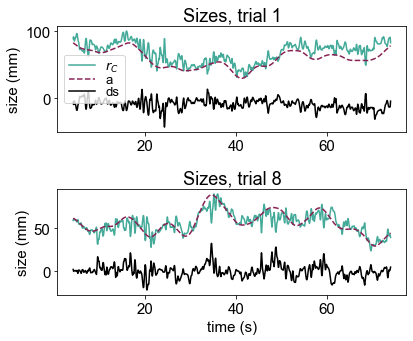

In [15]:
plt.figure(figsize=[6, 5])
plt.subplot(211)
plt.title("Sizes, trial 1")
d = data[0]
t = d.tr.t
take = np.arange(int(0/dt), int(70/dt))
plt.plot(t[take], d.rc[take], color = colors["cursor"], label=r"$r_C$")
plt.plot(t[take], d.a[take], "--", color = colors["target"], label=r"a")
plt.plot(t[take], d.ds[take], color="black", label=r"ds")
plt.ylabel("size (mm)")
plt.legend(loc="center left", prop={'size': 13}, labelspacing=0)

plt.subplot(212)
plt.title("Sizes, trial 8")
d = data[7]
t = d.tr.t
take = np.arange(int(0/dt), int(70/dt))
plt.plot(t[take], d.rc[take], color = colors["cursor"])
plt.plot(t[take], d.a[take], "--", color = colors["target"])
plt.plot(t[take], d.ds[take], color="black")
plt.ylabel("size (mm)")
plt.xlabel("time (s)")
plt.tight_layout()
plt.savefig("..//figures//Figure 4, sizes.eps", format="eps",bbox_inches="tight")

plt.show()

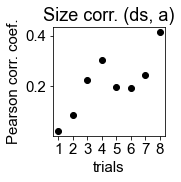

In [13]:
cc = lambda x,y: pearsonr(x,y)[0]
plt.figure(figsize=[2, 2])

corrs = [abs(cc(d.ds, d.a)) for d in data ]
x = np.arange(len(data)) + 1

plt.ylabel("Pearson corr. coef.")

plt.title(r"Size corr. (ds, a)")
plt.scatter(x, corrs, color="black")

plt.xticks(x)
plt.xlabel("trials")
plt.savefig("..//figures//Figure 4, sizes correlations.eps", format="eps",bbox_inches="tight")
plt.show()